# QEDi Superconducting Qubit Workshop: Workshop 3 - Transmon Characterization

So far, what have we done:
*    Understood how qubit states can be manipulated by a Hamiltonian
*    Designed a superconducting transmon chip using Qiskit Metal
*    Simulated and extracted the EJ and EC values from EM simulations

In [1]:
!pip install qutip

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from qutip import (Qobj, about, basis, coherent, coherent_dm, create, destroy,
                   expect, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, tensor, thermal_dm, Bloch, sesolve, sigmap, sigmam, mcsolve, num, qdiags, displace, steadystate)
# set a parameter to see animations in line
from matplotlib import rc
rc('animation', html='jshtml')
from qutip.ipynbtools import plot_animation

%matplotlib inline

# 1. Transmon Qubit

We will initialise the parameters of the Transmon: $E_J$, $E_C$ and $n_g$.

We will also define an $n_{cutoff}$, so the charge on the island is allowed to change between $N + n_{cutoff}$ and $N - n_{cutoff}$ - sets the dimension of the Hilbert space to $2n_{cutoff} + 1$

In [5]:
EJ = 20
EC = 0.2
ng = 0.0

n_cutoff = 10
dim = 2 * n_cutoff + 1

We shall then define the Cooper-Pair number $\hat{n}$ and the phase operator $\hat{\varphi}$.

The $\cos(\hat{\varphi})$ operator is expanded out in the number basis as an shifted diagonal matrix, which we will call $\hat{\varphi}_{\cos}$.

In [6]:
charge_states = np.arange(-n_cutoff, n_cutoff + 1)
n_op = qdiags(charge_states, 0)

cos_phi_op = qdiags(0.5 * np.ones(dim - 1), 1) + qdiags(0.5 * np.ones(dim - 1), -1)

identity_transmon = qeye(dim)

The Hamiltonian is then described as:
$\hat{H} = 4E_C (\hat{n} - n_g)^2 - E_J\hat{\varphi}_{\cos}$

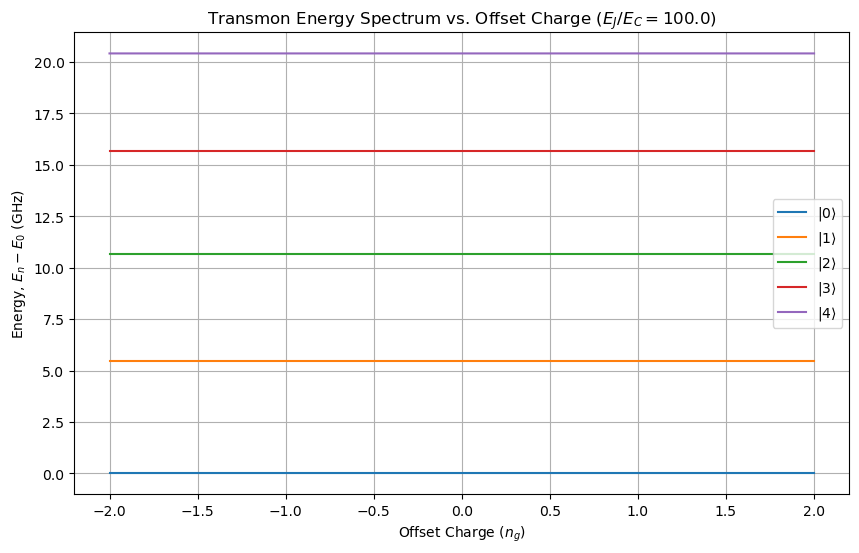

In [7]:
ng_vec = np.linspace(-2, 2, 201) # Vector of ng values to sweep over
num_levels = 5 # Number of energy levels to plot
energies = np.zeros((len(ng_vec), num_levels))

# 4. Loop over ng values and calculate eigenenergies
for i, ng in enumerate(ng_vec):
    # Update the Hamiltonian for the current ng value
    H = 4 * EC * (n_op - ng * identity_transmon)**2 - EJ * cos_phi_op

    # Calculate and store the lowest few eigenenergies
    evals = H.eigenenergies(eigvals=num_levels)
    energies[i, :] = evals

# 5. Plot the results
plt.figure(figsize=(10, 6))
for i in range(num_levels):
    # Subtract the ground state energy to see the transition energies more clearly
    plt.plot(ng_vec, energies[:, i] - energies[:, 0], label=f'$|{i}\\rangle$')

plt.title('Transmon Energy Spectrum vs. Offset Charge ($E_J/E_C = {:.1f}$)'.format(EJ / EC))
plt.xlabel('Offset Charge ($n_g$)')
plt.ylabel('Energy, $E_n - E_0$ (GHz)')
plt.legend()
plt.grid(True)
plt.show()

Play around with the values of the transmon to see how the energy bands change.

Make sure the above plot is flat in all the energy levels. If it is not, then change the values of $E_J$ and $E_C$.

We will redefine the Hamiltonian below with $n_g = 0$

In [8]:
ng = 0
H_transmon = 4 * EC * (n_op - ng * identity_transmon)**2 - EJ * cos_phi_op
eigenenergies, eigenstates = H_transmon.eigenstates()
print(H_transmon)

Quantum object: dims = [[21], [21]], shape = (21, 21), type = oper, isherm = True
Qobj data =
[[ 80.  -10.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [-10.   64.8 -10.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.  -10.   51.2 -10.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.  -10.   39.2 -10.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.  -10.   28.8 -10.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.  -10.   20.  -10.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.  -10.   12.8 -10.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0

# 2. Jaynes-Cumming Model for Transmon Readout

Now that we have a transmon qubit. We will now couple it to a resonator.

Let's define our resonator system.

In [9]:
wr = 5.4 # Changed resonator frequency to be closer to wq
N_res = 10 # Number of resonator fock states

identity_res = qeye(N_res)
a = destroy(N_res)

# This is just a Quantum Harmonic Oscillator (ignoring the zero point energy)
H_res = wr * a.dag() * a

Now we will introduce coupling between the transmon and the resonator systems via the Jaynes-Cumming Model.

Let's first isolate the first 2 levels of the transmon

In [10]:
transmon_evals, transmon_ekets = H_transmon.eigenstates(eigvals=2) # first two states of the transmon

# define the ground and the first excited state of the qubit
g_state = transmon_ekets[0]
e_state = transmon_ekets[1]

wq = transmon_evals[1] - transmon_evals[0] # qubit frequency
print(f"Transmon qubit frequency (wq): {wq:.4f} GHz")

Transmon qubit frequency (wq): 5.4490 GHz


We will define the qubit's lowering operator - this only involves the |1> to |0> decay transistion. We can define the excitation transition by taking the Hermitian of the operator.

In [11]:
sigma_minus = g_state * e_state.dag()

Tensor products allow you to treat the subsystems of the combined system separately in a different Hilbert space. The operators from different Hilbert spaces can commute freely, as opposed to the commutation relation required when within the same Hilbert space.

Then we construct the full Hamiltonian in this combined double Hilbert space.

In [12]:
g = 0.1 # Coupling strength between the transmon and resonator systems in GHz

E_g = eigenenergies[0]
H_transmon_shifted = H_transmon - E_g * identity_transmon # shift the hamiltonian so the ground state is at 0

# Transmon hamiltonian in the combined Hilbert space
H_transmon_full = tensor(H_transmon_shifted, identity_res)

# Resonator Hamiltonian in the combined Hilbert space
H_resonator_full = tensor(identity_transmon, H_res)


# qubit's decay transition operator
sm_full = tensor(sigma_minus, qeye(N_res))

# resonator's annihilation operator
a_full = tensor(qeye(dim), a)

# Interaction Hamiltonian in the rotating-wave approximation (RWA)
H_int = g * (sm_full.dag() * a_full + sm_full * a_full.dag())

# 3. The Jaynes-Cumming Hamiltonian
H_JC = H_transmon_full + H_resonator_full + H_int

In [13]:
evals, ekets = H_JC.eigenstates(eigvals=5)

print("--- Corrected Jaynes-Cummings Eigenenergies (g = 0.1 GHz) ---")
# Print energies relative to the new ground state
ground_state_energy = evals[0]
for i, energy in enumerate(evals):
    print(f"State {i}: {energy - ground_state_energy:.4f} GHz")

# We expect the first two excited states to be near wq and wr (~5.4 GHz)
# and split by the coupling.
print(f"\nQubit Frequency (wq): {wq:.4f} GHz")
print(f"Resonator Frequency (wr): {wr:.4f} GHz")

--- Corrected Jaynes-Cummings Eigenenergies (g = 0.1 GHz) ---
State 0: 0.0000 GHz
State 1: 5.3216 GHz
State 2: 5.5275 GHz
State 3: 10.6790 GHz
State 4: 10.6810 GHz

Qubit Frequency (wq): 5.4490 GHz
Resonator Frequency (wr): 5.4000 GHz


Above we can see, that states 1 and 2 are close to each other (also 3 and 4). This corresponds to |e, 0> and |g, 1> states, i.e. depending on whether the qubit was excited or the resonator, the states are slightly split. This splitting is related to the coupling strength and the difference of the qubit and the resonator frequency.

This is known as a **dressed-qubit**, as the qubit energy levels are changed by the coupling introduced by the resonator.

# Dispersive Readout Measurement of the Transmon Qubit via Resonator

In [16]:
E_g0 = evals[0]  # Energy of the |g,0> state (ground state)
E_g1 = evals[1]  # Energy of the |g,1>-like state
E_e0 = evals[2]  # Energy of the |e,0>-like state
E_e1 = evals[4]  # Energy of the |e,1>-like state

# Calculate the resonator frequency when the qubit is in the ground state
wr_g = E_g1 - E_g0

# Calculate the resonator frequency when the qubit is in the excited state
wr_e = E_e1 - E_e0

print(f"Resonator dressed-frequency when qubit is in |0> state: {wr_g}")
print(f"Resonator dressed-frequency when qubit is in |1> state: {wr_e}")

Resonator dressed-frequency when qubit is in |0> state: 5.321552812120906
Resonator dressed-frequency when qubit is in |1> state: 5.153509072281588


We will probe the qubit-resonator system using an external signal (readout probe). We will sweep the frequency of the probe across a range of frequency.

When the probe signal is in resonance with the system's dressed energy level, the transmission through the system will be maximised.

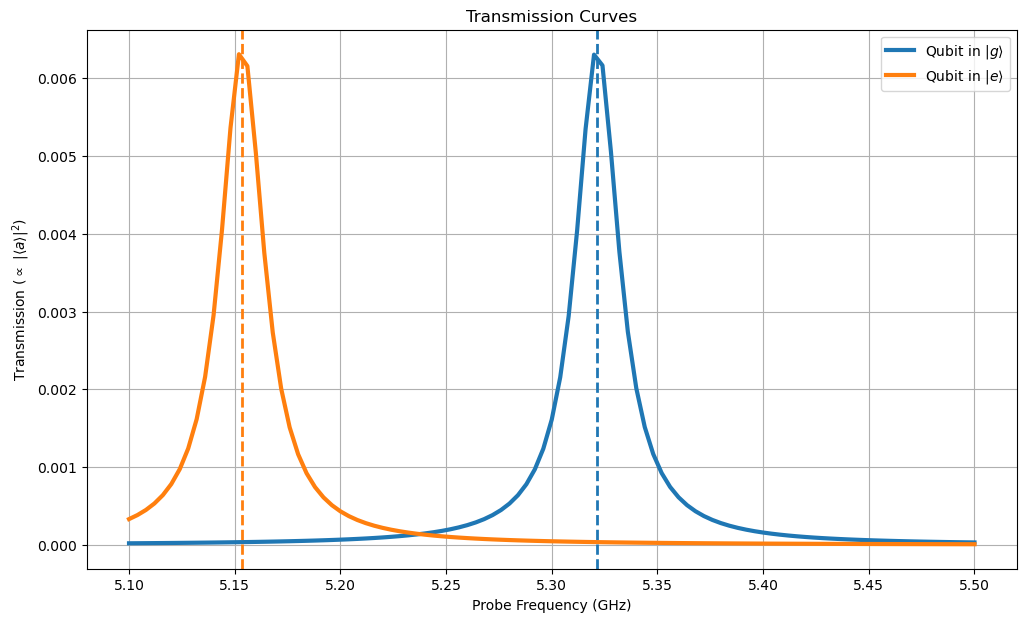

In [19]:
# We will introduce some variable to make it a bit more realistic 
kappa = 0.025      # Resonator photon decay rate (linewidth)
probe_amp = 0.001  # Amplitude of the weak probe tone

# Define the annihilation operator for our small resonator system
a = destroy(N_res)

# Define the frequency range to sweep the probe tone
probe_freqs = np.linspace(5.1, 5.5, 101)

# Lists to store the results
a_g_values = []
a_e_values = []

# We are using a simplified Hamiltonian to make sure the below sims don't break out computers.
for w_p in probe_freqs:
    # Case 1: Simulate the resonator as if the qubit is ground
    H_g = (wr_g - w_p) * a.dag() * a + probe_amp * (a + a.dag())
    c_ops = [np.sqrt(kappa) * a]
    rho_ss_g = steadystate(H_g, c_ops)
    a_g_values.append(expect(a, rho_ss_g))

    # Case 2: Simulate the resonator as if the qubit is excited
    H_e = (wr_e - w_p) * a.dag() * a + probe_amp * (a + a.dag())
    rho_ss_e = steadystate(H_e, c_ops)
    a_e_values.append(expect(a, rho_ss_e))

# The transmission is proportional to the magnitude squared of <a>
transmission_g = np.abs(a_g_values)**2
transmission_e = np.abs(a_e_values)**2


plt.figure(figsize=(12, 7))
plt.plot(probe_freqs, transmission_g, label=f'Qubit in $|g\\rangle$', lw=3)
plt.plot(probe_freqs, transmission_e, label=f'Qubit in $|e\\rangle$', lw=3)
plt.axvline(wr_g, color='C0', linestyle='--', lw=2)
plt.axvline(wr_e, color='C1', linestyle='--', lw=2)
plt.title('Transmission Curves')
plt.xlabel('Probe Frequency (GHz)')
plt.ylabel('Transmission ($\propto$ $|\\langle a \\rangle|^2$)')
plt.legend()
plt.grid(True)
plt.show()
